In [1]:
import os
import gym
import asyncio
import numpy as np
from datetime import datetime
from gym_derk.envs import DerkEnv
from gym_derk import ObservationKeys, ActionKeys, TeamStatsKeys
import tensorflow.compat.v1 as tf_v1
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras import regularizers, constraints, backend, layers, optimizers, Model, Input

In [2]:
TF_CONFIG = tf_v1.ConfigProto(gpu_options=tf_v1.GPUOptions(per_process_gpu_memory_fraction=0.7),
                              allow_soft_placement=True)

In [3]:
%cd /home/rajk/Machine_Learning/RL_OpenAI_Gym
from src.Buffer import ReplayBuffer
from src.utils import polyak_average
from src.progressbar import ProgressBar

/home/rajk/Machine_Learning/RL_OpenAI_Gym


In [4]:
def get_critic(state_size, action_size, name="critic", **layer_kwargs):
    state_in = Input(shape=(state_size, ), name="state_in", dtype="float32")
    action_in = Input(shape=(action_size, ), name="action_in", dtype="float32")
    x = layers.Concatenate()([state_in, action_in])
    x = layers.Dense(256, **layer_kwargs)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(256, **layer_kwargs)(x)
    q_out = layers.Dense(1)(x)
    model = Model(inputs=[state_in, action_in], outputs=[q_out], name=name)
    return model
    
def get_actor(state_size, name="actor", **layer_kwargs):
    state_in = Input(shape=(state_size, ), name="state_in", dtype="float32")
    x = layers.Dense(256, **layer_kwargs)(state_in)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(256, **layer_kwargs)(x)
    # Output actions
    move_x = layers.Dense(1, activation="tanh")(x)
    rotate = layers.Dense(1, activation="tanh")(x)
    chase_focus = layers.Dense(1, activation="sigmoid")(x)
    casting_slot_probs = layers.Dense(4, activation="softmax")(x)
    casting_slot = tf_v1.cast(tf_v1.argmax(casting_slot_probs, axis=-1), dtype="float32")
    casting_slot = tf_v1.expand_dims(casting_slot, axis=-1)
    change_focus_probs = layers.Dense(8, activation="softmax")(x)
    change_focus = tf_v1.cast(tf_v1.argmax(change_focus_probs, axis=-1), dtype="float32")
    change_focus = tf_v1.expand_dims(change_focus, axis=-1)
    outputs = tf_v1.concat([move_x, rotate, chase_focus, casting_slot, change_focus], axis=-1)
    model = Model(inputs=[state_in], outputs=outputs, name=name)
    return model

class MADDPGAgent:
    
    DEFAULT_WEIGHTS = np.array([0.25, 0.25, 0.5, 1, 1])
    
    def __init__(self, env, sess, summary_dir=None, batch_size=32, gamma=0.997, tau=0.05, policy_lr=3e-4, q_lr=3e-4, eps=0.5, noise_weights=None, 
                 weight_decay=0.995, reward_scale=1.0, record_interval=1, init_explore_samples=300, layer_kwargs={}):
        self.env = env
        self.sess = sess
        self.batch_size = batch_size
        self.gamma = gamma
        self.q_lr = q_lr
        self.policy_lr = policy_lr
        self.eps = eps
        self.tau = tau
        self.reward_scale = reward_scale
        self.summary_dir = summary_dir
        self.record_interval = record_interval
        self.record = False
        self.record_path = None
        self.noise_weights = self.DEFAULT_WEIGHTS if noise_weights is None else noise_weights
        self.weight_decay = weight_decay
        self.layer_kwargs = layer_kwargs
        self.state_size = len(ObservationKeys)
        self.action_size = len(ActionKeys)    # movex, rotate, chase_focus, casting_slot, change_focus
        self.replay_buffer = ReplayBuffer(5000000)
        self.init_explore_samples = init_explore_samples
        
        self.states_ph = None
        self.actions_ph = None
        self.next_states_ph = None
        self.rewards_ph = None
        self.dones_ph = None
        
        self.team_stats = []
        self.epoch_rewards = []
        self.epoch_reward = None
        self.epoch_length = 0
        self.steps = 0
        self.epoch = 0
        
        self.actors = []
        self.target_actors = []
        self.critic = None
        self.target_critic = None
        self.actor_train_ops = []
        self.critic_train_ops = []
        self.summary_dict = {}
        self.init()
    
    def init(self):
        self.states_ph = tf_v1.placeholder(shape=(None, self.state_size), name="states", dtype="float32")
        self.actions_ph = tf_v1.placeholder(shape=(None, self.action_size), name="actios", dtype="float32")
        self.next_states_ph = tf_v1.placeholder(shape=(None, self.state_size), name="next_states", dtype="float32")
        self.rewards_ph = tf_v1.placeholder(shape=(None, 1), name="rewards", dtype="float32")
        self.dones_ph = tf_v1.placeholder(shape=(None, 1), name="dones", dtype="float32")
        self.init_actor_critic()
        self.update_weights(tau=1.0)
    
    def init_actor_critic(self):
        # Create actors and critics
        for agent_id in range(self.env.n_agents):
            agent_name = f"agent_{agent_id}"
            actor = get_actor(state_size=self.state_size, name=f"{agent_name}_actor", **self.layer_kwargs)
            target_actor = get_actor(state_size=self.state_size, name=f"{agent_name}_target_actor", **self.layer_kwargs)
            self.actors.append(actor)
            self.target_actors.append(target_actor)
        self.critic = get_critic(state_size=self.state_size, action_size=self.action_size, name="critic", **self.layer_kwargs)
        self.target_critic = get_critic(state_size=self.state_size, action_size=self.action_size, name="target_critic", **self.layer_kwargs)
        self.init_critic_loss()
        for actor in self.actors:
            self.init_actor_loss(actor)
        print("Initialized actors and critics!")
        
    
    def init_actor_loss(self, actor):
        actions = actor(self.states_ph)
        q_value = self.critic([self.states_ph, actions])
        loss = -tf_v1.reduce_mean(q_value)
        opt = tf_v1.train.AdamOptimizer(learning_rate=self.policy_lr)
        train_op = opt.minimize(loss=loss, var_list=actor.trainable_variables)
        self.actor_train_ops.append(train_op)    
    
    def init_critic_loss(self):
        q_targets = tf_v1.stop_gradient(self.get_q_targets())
        predicted_qs = self.critic([self.states_ph, self.actions_ph])
        loss = tf_v1.losses.mean_squared_error(q_targets, predicted_qs)
        opt = tf_v1.train.AdamOptimizer(learning_rate=self.q_lr)
        train_op = opt.minimize(loss=loss, var_list=self.critic.trainable_variables)
        self.critic_train_ops.append(train_op)
    
    def get_q_targets(self):
        # Experiment get mean next_q from all actors
        """next_actions_n = [actor(self.next_states_ph) for actor in self.target_actors]
        next_qs_n = [self.target_critic([self.next_states_ph, next_actions]) for next_actions in next_actions_n]
        next_qs = tf_v1.reduce_mean(next_qs_n, axis=0)"""
        next_actions = self.target_actors[0](self.next_states_ph)
        next_qs = self.target_critic([self.next_states_ph, next_actions])
        q_targets = self.rewards_ph + self.gamma*(1-self.dones_ph)*next_qs
        return q_targets
    
    def sample_batch(self):
        # Experiment: Train each agent on exp from all agents
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        # Stack exp from each agent to train each of them from exp from all agents
        states = states.reshape((-1, states.shape[-1]))
        actions = actions.reshape((-1, actions.shape[-1]))
        rewards = rewards.reshape((-1, rewards.shape[-1]))
        next_states = next_states.reshape((-1, next_states.shape[-1]))
        # Change dones = [[0], [1], ..., [0]] into dones = [[0], [0], [1], [1], ..., [0], [0]] if num_agents == 2
        dones = np.tile(dones, env.n_agents).reshape((-1, dones.shape[-1]))
        return states, actions, rewards, next_states, dones
    
    def train(self, states, actions, rewards, next_states, dones):
        feed_dict = {self.states_ph: states, 
                     self.actions_ph: actions, 
                     self.rewards_ph: rewards, 
                     self.next_states_ph: next_states, 
                     self.dones_ph: dones}
        self.sess.run(self.critic_train_ops, feed_dict=feed_dict)
        
        # sample_indexes = np.arange(self.env.n_agents)
        # np.random.shuffle(sample_indexes)
        for i, train_op in enumerate(self.actor_train_ops):
            feed_dict = {self.states_ph: states[i::self.batch_size], 
                         self.actions_ph: actions[i::self.batch_size], 
                         self.rewards_ph: rewards[i::self.batch_size], 
                         self.next_states_ph: next_states[i::self.batch_size], 
                         self.dones_ph: dones[i::self.batch_size]}
            self.sess.run(train_op, feed_dict=feed_dict)
        # Experiment train one actor using the exp and set other's parameter to noisy parameter of the main actor
        # self.sess.run(self.actor_train_ops[0], feed_dict=feed_dict)
        
    
    def blur_actor_weights(self):
        for actor in self.actors:
            actor.set_weights([value + np.random.normal(0.0, 0.33, size=value.shape)
                               for value in actor.get_weights()])
    
    def _update_weights(self, src_network, target_network, tau=None):
        tau = tau or self.tau
        src_params = src_network.get_weights()
        target_params = target_network.get_weights()
        target_network.set_weights([polyak_average(src_value, target_value)
                                    for (src_value, target_value) in zip(src_params, target_params)])
    
    def update_weights(self, tau=None):
        self._update_weights(src_network=self.critic, target_network=self.target_critic, tau=tau)
        for actor, target_actor in zip(self.actors, self.target_actors):
            self._update_weights(src_network=actor, target_network=target_actor, tau=tau)
        # Experiment: New critic param = Polyak avg between new target and old critic params.
        # Hopefully, it will prevent critic params from getting too large compared to target params as the training continues
        # self._update_weights(src_network=self.target_critic, target_network=self.critic, tau=tau)
    
    
    def clip_action(self, action):
        action[0] = np.clip(action[0], -1.0, 1.0)
        action[1] = np.clip(action[1], -1.0, 1.0)
        action[2] = np.clip(action[2], 0, 1.0)
        action[3] = np.clip(round(action[3]), 0, 3)
        action[4] = np.clip(round(action[4]), 0, 7)
        return action
    
    def decay_noise_weights(self):
        self.noise_weights *= self.weight_decay
    
    def add_noise(self, action):
        # noise = np.random.uniform(-1.0, 1.0, size=action.shape)
        noise = np.random.normal(0, 1.0, size=action.shape)
        action = action + self.noise_weights*noise.T
        action = self.clip_action(action)
        return action
    
    def _action(self, actor, state, eps=None):
        state = np.expand_dims(state, axis=0)
        action = actor.predict(state)[0]
        if np.random.uniform(0, 1) < eps:
            action = self.add_noise(action)
        return action
    
    def action(self, state_n, eps=None):
        if eps is None:
            eps = self.eps
        action_n = np.array([self._action(actor, state, eps=eps) for (actor, state) in zip(self.actors, state_n)])
        return action_n
    
    def explore_samples(self):
        num_samples = self.init_explore_samples
        samples_collected = 0
        pbar = ProgressBar(num_samples, title=f"Exploring env: ", info_text="Collected ({samples_collected}/%s) samples"%(num_samples))
        while samples_collected < num_samples:
            done = [False]
            state = self.env.reset()
            while not all(done) and (samples_collected < num_samples):
                action = np.array([self.env.action_space.sample() for _ in range(self.env.n_agents)])
                next_state, reward, done, info = self.env.step(action)
                reward = reward*self.reward_scale
                transition = (state, action, np.expand_dims(reward, axis=-1), next_state, np.expand_dims(done, axis=-1))
                self.replay_buffer.add(transition)
                samples_collected += 1
                pbar.step(step=1, samples_collected=samples_collected)
    
    def step(self, state):
        action = self.action(state)
        next_state, reward, done, info = self.env.step(action)
        self.call_after_step(state, action, reward, next_state, done)
        return next_state, done
    
    def capture_screenshot(self, path):
        async def take_screenshot(path):
            await self.env.app.page.screenshot({'path': path})
        asyncio.get_event_loop().run_until_complete(take_screenshot(path))
    
    def call_after_step(self, state, action, reward, next_state, done):
        reward = reward*self.reward_scale
        transition = (state, action, np.expand_dims(reward, axis=-1), next_state, np.expand_dims(done, axis=-1))
        self.replay_buffer.add(transition)
        if self.epoch_reward is None:
            self.epoch_reward = reward
        else:
            self.epoch_reward += reward
        self.team_stats.append(env.team_stats)
        if self.record:
            img_path = os.path.join(self.record_path, f"image_{self.epoch_length}.png")
            self.capture_screenshot(img_path)
        train_samples = self.sample_batch()
        if self.steps%20 == 0:
            self.train(*train_samples)
            self.update_weights()
        self.steps += 1
        self.epoch_length += 1
    
    def call_before_epoch(self, last_epoch=False):
        self.epoch_reward = None
        self.epoch_length = 0
        self.record = (self.epoch % self.record_interval == 0) or last_epoch
        if self.record:
            self.record_path = os.path.join(self.summary_dir, f"epoch_{self.epoch}") 
            os.makedirs(self.record_path, exist_ok=True)            
        
    def _run_once(self):
        state = self.env.reset()
        done = [False]
        while not all(done):
            state, done = self.step(state)
    
    def init_summaries(self):
        pass
    
    def call_before_train(self):
        self.init_summaries()
        self.sess.run(tf_v1.global_variables_initializer())
        self.explore_samples()
        
    def run(self, total_epochs):
        self.call_before_train()
        progressbar = ProgressBar(total_epochs, title="Training agent:", info_text="Epoch: ({epoch}/%s)"%(total_epochs))
        for self.epoch in range(1, total_epochs + 1):
            self.call_before_epoch(last_epoch=self.epoch==total_epochs)
            self._run_once()
            self.call_after_epoch()
            progressbar.step(epoch=self.epoch)
        self.call_after_train()
    
    def call_after_epoch(self):
        self.epoch_rewards.append(self.epoch_reward)
        self.decay_noise_weights()
        self.blur_actor_weights()
    
    def call_after_train(self):
        pass
    
    def save(self, dump_dir):
        models = self.actors + self.target_actors + [self.critic, self.target_critic]
        for model in models:
            model.save(os.path.join(dump_dir, f"{model.name}.h5"), include_optimizer=False)
        print(f"# Saved {len(models)} models to {dump_dir}")

In [5]:
epochs = 1000
date_time = datetime.now().strftime("%d.%m.%Y_%H.%M")

agent_kwargs = {
    "q_lr": 1e-3, 
    "policy_lr": 3e-4, 
    "tau": 5e-3,
    "eps": 0,
    "gamma": 0.992,
    "batch_size": 32,
    "reward_scale": 1,
    "record_interval": 10,
    "init_explore_samples": 150,
    "summary_dir": os.path.join("summaries", f"derk_gym_{date_time}"),
    "noise_weights": np.array([0.25, 0.25, 0.4, 1, 1]),
    "weight_decay": 0.997,
    "layer_kwargs":{
        "activation": "relu",
        "kernel_constraint": None,
        "kernel_regularizer": regularizers.l2(1e-5),
    }
}

In [6]:
rewardDict = {
    "damageEnemyStatue": 0, # 0.03,
    "damageEnemyUnit": 0, # 0.02,
    "healFriendlyStatue": 0, # 0.025,
    "friendlyFire": -0.01,
    "healTeammate1": 0, # 0.015,
    "healTeammate2": 0, # 0.015,
    "killEnemyStatue": 4,
    "killEnemyUnit": 1,
    "damageTaken": 0, # -0.005,
    "healEnemy": 0, # -0.03, 
    "fallDamageTaken": -0.04, 
    "statueDamageTaken": 0, # -0.00, 
    "teamSpirit": 1.0,
}

base_team_config = {
    "primaryColor": "#aa0000", 
    "slots": ["Cleavers", "Blaster", "HealingGland"], 
    "rewardFunction": rewardDict.copy()
}

home_config = base_team_config.copy()
away_config = base_team_config.copy()
home_config.update({'primaryColor': "#005500", "secondaryColor": "#000000", "eyes": 5})
away_config.update({'primaryColor': "#550000", "secondaryColor": "#555555", "ears": 4})
home_config["rewardFunction"].update({"teamSpirit": 0.2})
away_config["rewardFunction"].update({"teamSpirit": 0.8})
env_kwargs = {
    "home_team": [home_config]*3, 
    "away_team": [away_config]*3,
    "session_args": {
        "turbo_mode": False
    }
}

In [7]:
try:
    env = DerkEnv(**env_kwargs)
except OSError as er:
    pass
backend.clear_session()
with tf_v1.Session(config=TF_CONFIG) as sess:
    agent = MADDPGAgent(env, sess, **agent_kwargs)
    agent.run(epochs)
    model_dir = os.path.join(agent_kwargs["summary_dir"], "models")
    os.makedirs(model_dir, exist_ok=True)
    agent.save(model_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Initialized actors and critics!
Exploring env:  ██████████████████████████████████████████████████ 100.00% | mean time per iter: 0.13 s | time left: 00:00 | Collected (150/150) samples 
Training agent: ██████████████████████████████████████████████████ 100.00% | mean time per iter: 20.39 s | time left: 00:00 | Epoch: (1000/1000) 
# Saved 14 models to summaries/derk_gym_21.02.2021_00.16/models


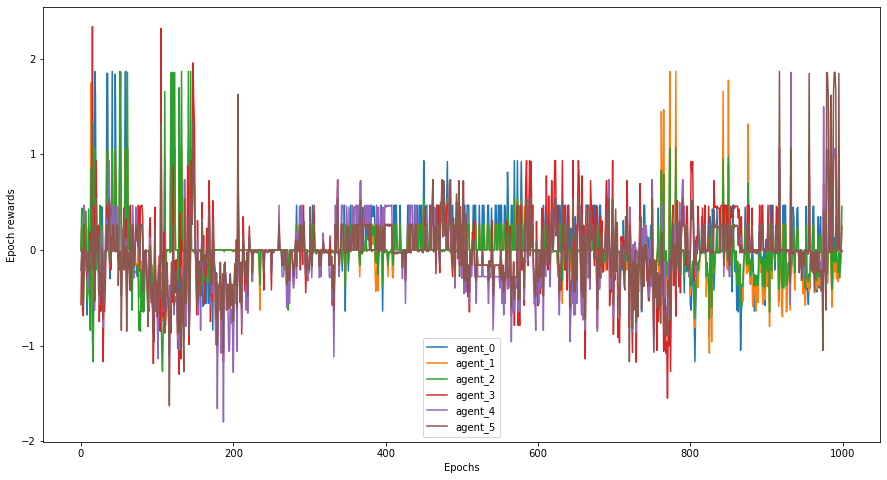

In [13]:
plt.figure(figsize=(15, 8))
rewards_summary = np.array(agent.epoch_rewards)
for i in range(env.n_agents):
    plt.plot(rewards_summary[:, i], label=f"agent_{i}")
plt.ylabel("Epoch rewards")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(os.path.join(agent.summary_dir, "reward_plot.png"))
plt.show()

/home/rajk/miniconda3/envs/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


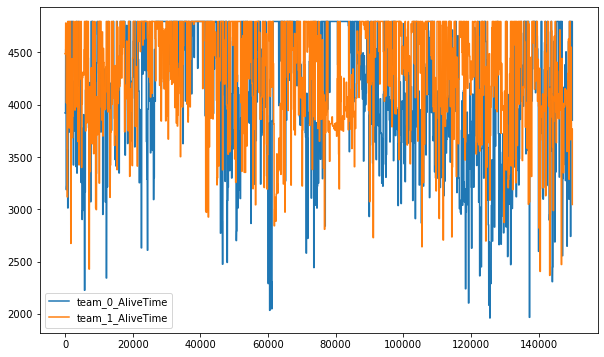

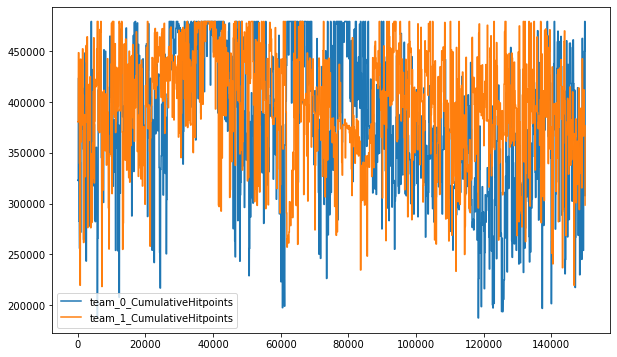

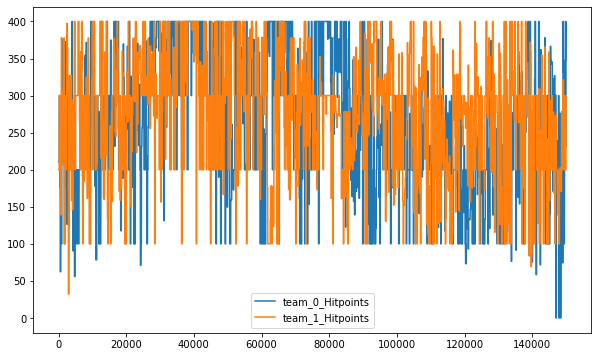

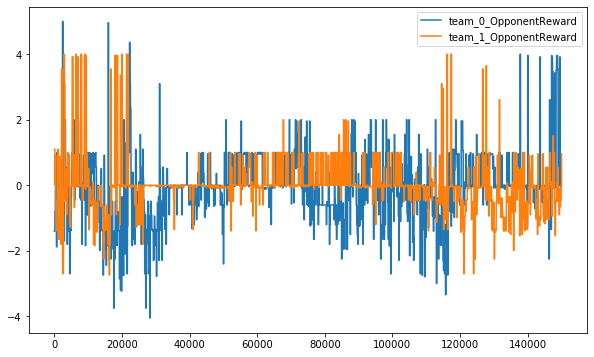

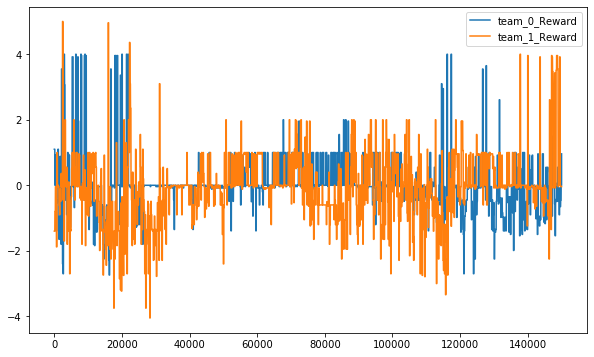

In [9]:
keys = [key for key in dir(TeamStatsKeys) if not key.startswith("_")]
history = np.array(agent.team_stats)
for k in keys:
    plt.figure(figsize=(10, 6))
    for i in range(history.shape[1]):
        v = getattr(TeamStatsKeys, k).value
        plt.plot(history[:, i, v], label=f"team_{i}_{k}")
    plt.legend()
plt.show()

In [10]:
env.close()

# TODO:
1. ~~Save models~~
2. ~~Option to learn from other's exp too~~
3. Implement genetic algorithm
4. Check if rewards are working properly
5. ~~Update each agent on different batch samples~~
6. Restore models and test on other agents
7. Log training summarries
8. Train using multiple arena
9. Assign different eps values to different agents of the team
10. Train 1 actor with DDPG and set other actors#s parameters as noisy vesion of the main actor 